In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as plt
import statsmodels.api as sm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import classification_report

# %matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 30)

# 데이터분석 스케치

## [Horse colic](https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+)

+ team 
  + 권순호, 윤지원, 김원정
  

+ index
	* EDA(Exploratory data analysis)
	* Feature selection
	* Modeling
	* Model selection

## EDA
+ 변수 탐색 및 분류
  + 변수 이름과 설명
  + 상관관계가 없는 변수는 어떤것이 있나?
  + 의미없는값, 전처리가 필요한 값들을 선별및 가공하자

In [3]:
df = pd.read_csv('./horse.csv')
df['outcome'] = df.pop('outcome')

In [4]:
df.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,extreme_pain,absent,severe,NaN,NaN,NaN,decreased,distend_large,45.0,8.4,NaN,NaN,no,11300,0,0,no,died
1,yes,adult,534817,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,mild_pain,absent,slight,NaN,NaN,NaN,absent,other,50.0,85.0,cloudy,2.0,no,2208,0,0,no,euthanized
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,mild_pain,hypomotile,none,NaN,NaN,NaN,normal,normal,33.0,6.7,NaN,NaN,no,0,0,0,yes,lived
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,depressed,absent,severe,none,less_1_liter,5.0,decreased,NaN,48.0,7.2,serosanguious,5.3,yes,2208,0,0,yes,died
4,no,adult,530255,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0,7.4,NaN,NaN,no,4300,0,0,no,died


In [5]:
null_count = pd.DataFrame(df.isnull().sum().sort_values(ascending=False))
null_count['percentage'] = null_count/len(df)

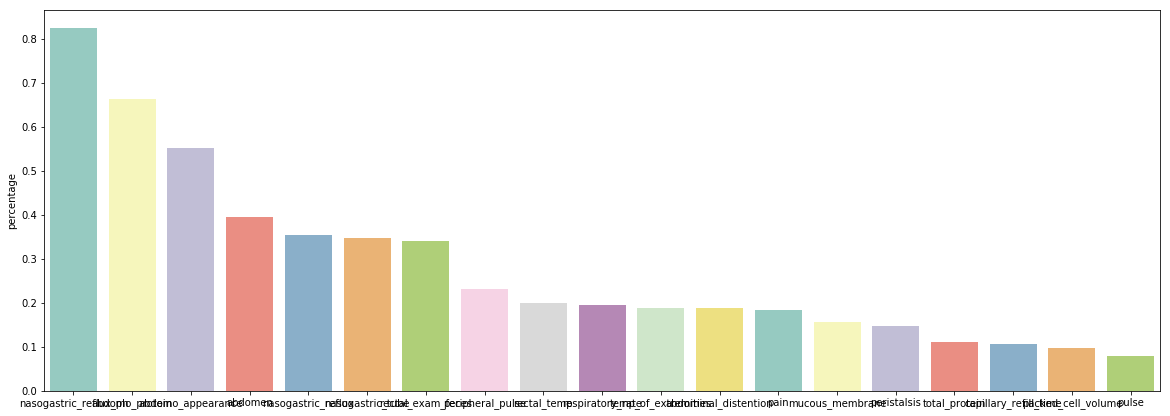

In [6]:
plt.figure(figsize=(20, 7))
sns.barplot(x=null_count.head(19).index, y='percentage', data=null_count.head(19), palette="Set3")
plt.show()

In [7]:
cate = ['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 
       'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 
       'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion', 'cp_data']
numeric = ['rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 
           'total_protein', 'abdomo_protein']

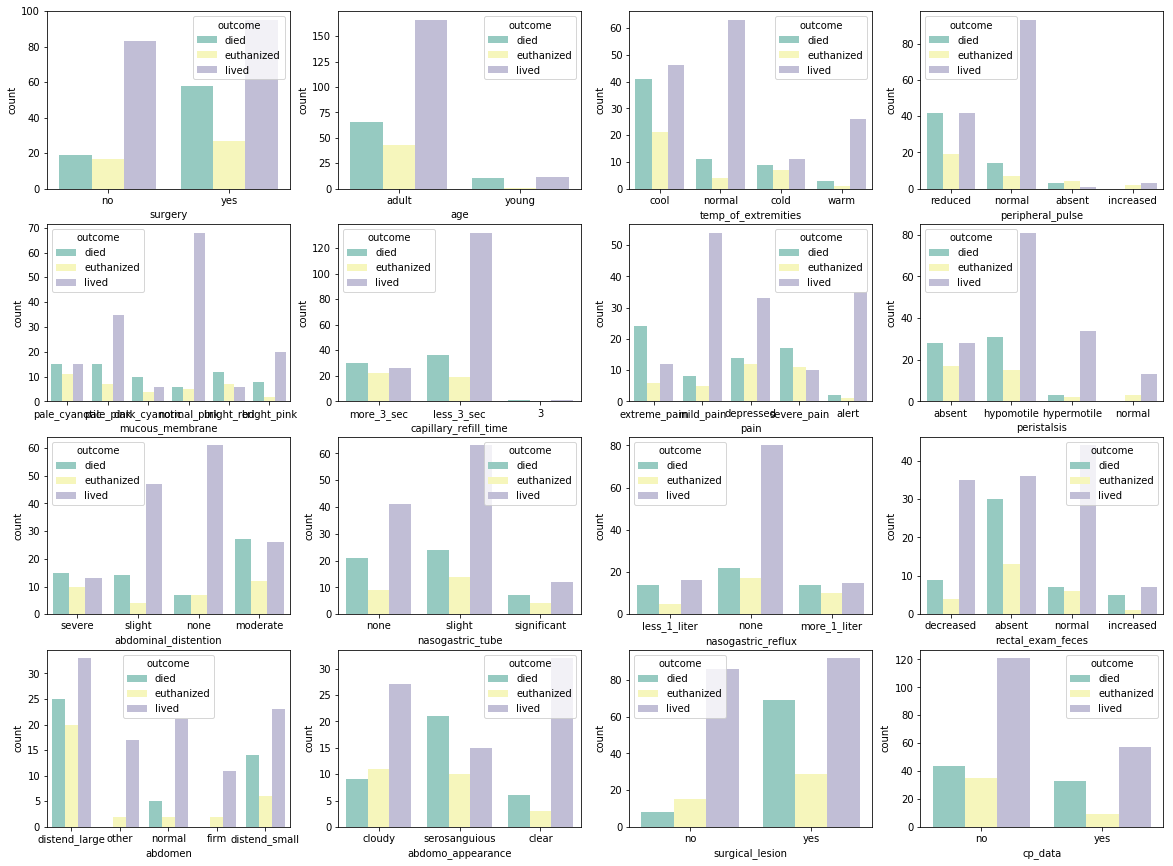

In [8]:
plt.figure(figsize=(20, 15))
for i, feature in enumerate(cate):
    plt.subplot(4,4,i+1)
    sns.countplot(feature, hue='outcome', data=df, palette="Set3")
plt.show()

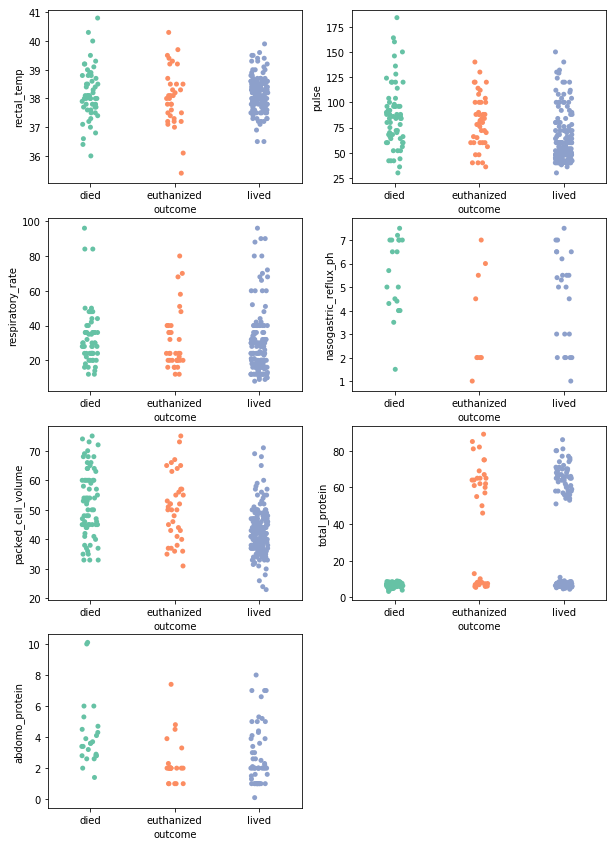

In [9]:
plt.figure(figsize=(10, 30))
for i, feature in enumerate(numeric):
    plt.subplot(8,2,i+1)
    sns.stripplot("outcome", feature, data=df, jitter=True, palette="Set2")
plt.show()

### 변수 이름과 설명 :

In [10]:
def cat_plot(feature, df=df, outcome='outcome', size=(10,3), palette='Set3'):
    plt.figure(figsize=size)
    plt.subplot(1,3,1)
    sns.countplot(x=feature, data=df, palette="Set3")
    plt.subplot(1,3,2)
    sns.countplot(outcome, hue=feature, data=df, palette="Set3")
    plt.subplot(1,3,3)
    sns.countplot(feature, hue=outcome, data=df, palette="Set3")
    plt.show()
    return None

In [11]:
def missing_per(feature):
    percentage = df[feature].isnull().sum() / len(df[feature]) * 100
    return percentage

surgery?(수술 경험)
  - 1 = Yes, it had surgery
  - 2 = No, It was treated without surgery

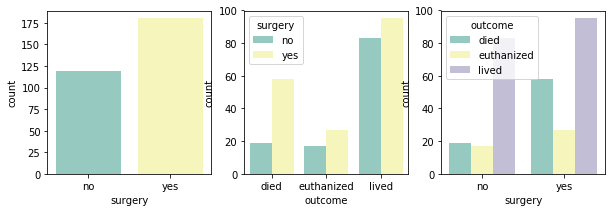

In [12]:
cat_plot("surgery")

Age(나이)
- 1 = 성인 말
- 2 = 어린 말 (< 6개월)

In [13]:
df['age'].value_counts()

adult    275
young     24
Name: age, dtype: int64

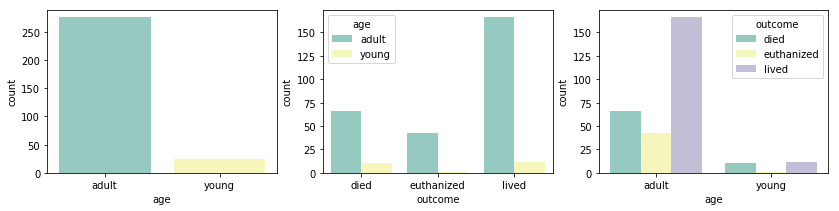

In [14]:
cat_plot("age", size=(14, 3))

Hospital Number(병원 번호)
 - 숫자 ID
 - 말에 지정된 case number
      (만약 말을 1회 이상 치료한다면 특별하지 않을 수 있다.)

rectal temperature(직장 온도)
 - linear
 - in degrees celsius.
 - 감염으로 인해 고온이 발생할 수 있습니다.
 - 동물이 late shock을 받으면 온도가 낮아질 수 있다.
 - 정상 온도는 37.8
 - 이 매개 변수는 일반적으로 문제가 진행됨에 따라 변경됩니다. (예를 들어, 말이 충격에 빠질 때 정상 범위를 통과하면서 병변 때문에 상승할 수 있습니다.)
       

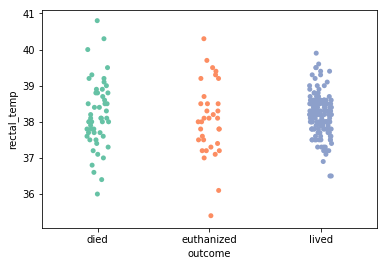

In [15]:
sns.stripplot("outcome", "rectal_temp", data=df, jitter=True, palette='Set2')
plt.show()

pulse(맥박)
 - linear
 - 분당 심장 박동 수
 - is a reflection of the heart condition: 30-40은 성인에게 정상입니다.
 - 경주용 말이지만 일반 말보다 심장박동수가 낮다(분당 20-25정도)
 - 통증이있는 병변이 있거나 순환계 충격을 겪은 동물은 심박수가 상승 할 수 있습니다

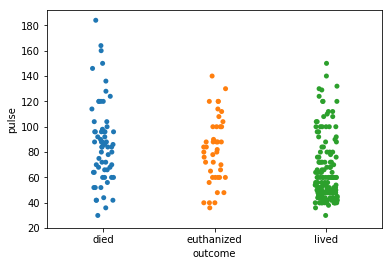

In [16]:
sns.stripplot("outcome", "pulse", data=df, jitter=True)
plt.show()

respiratory rate(호흡 속도)
 - linear
 - normal rate is 8 to 10
 - 심한 변동 때문에 유용성이 의심스럽습니다.

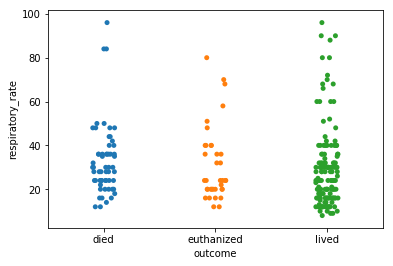

In [17]:
sns.stripplot("outcome", "respiratory_rate", data=df, jitter=True)
plt.show()

temperature of extremities(팔 다리의 온도)
 - 말초 혈액 순환의 주관적 표시
 - possible values:
   - 1 = Normal
   - 2 = Warm
   - 3 = Cool
   - 4 = Cold
 - cool와 cold는 쇼크의 가능성을 보여줍니다.
 - 고열 사지는 직장 온도 상승과 관련이 있습니다.

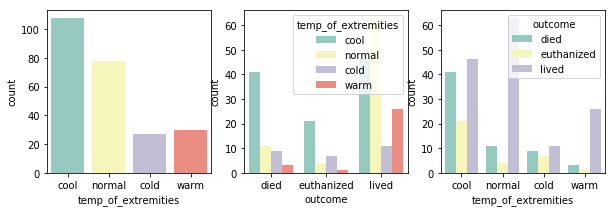

In [18]:
cat_plot("temp_of_extremities")

peripheral pulse(말초 맥박)
 - subjective
 - possible values are:
   - 1 = normal
   - 2 = increased
   - 3 = reduced
   - 4 = absent
 - normal or increased p.p.는 적절한 순환을 나타내며 reduced or absent는 나쁜 perfusion을 나타냅니다.

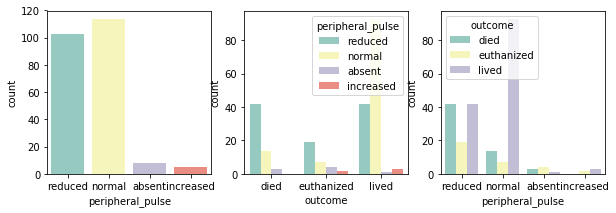

In [19]:
cat_plot("peripheral_pulse")

mucous membranes(점막)
 - 주관적인 색의 측정
 - possible values are:
   - 1 = normal pink
   - 2 = bright pink
   - 3 = pale pink
   - 4 = pale cyanotic
   - 5 = bright red / injected
   - 6 = dark cyanotic
 - 1, 2는 정상 또는 약간 증가 된 혈액 순환을 나타냅니다
 - 3 는 early shock 발생일수도 있습니다.
 - 4,6 은 심각한 순환 기관의 손상을 나타낸다.
 - 5는 패혈증을 더 많이 나타낸다.

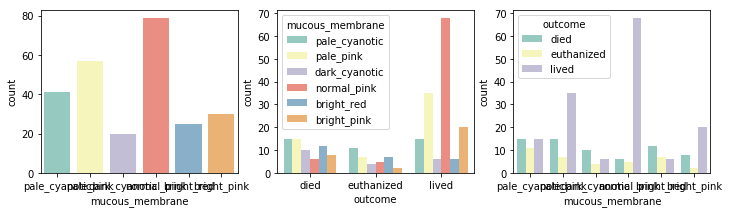

In [20]:
cat_plot("mucous_membrane", size=(12, 3))

capillary refill time(모세관 주입 시간)
  - 임상 적 판단. 리필 시간이 길수록 혈액 순환이 원활하지 않음.
  - possible values
    - 1 = < 3 seconds
    - 2 = >= 3 seconds

In [21]:
df['capillary_refill_time'].replace({'3': 'more_3_sec'}, inplace=True)

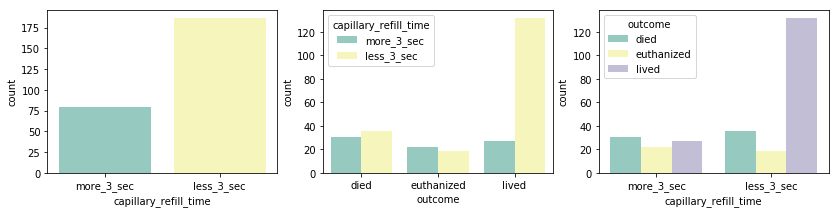

In [22]:
cat_plot("capillary_refill_time", size=(14, 3))

pain 
  - 말의 통증 수준에 대한 주관적인 판단
  - possible values:
    - 1 = alert, no pain
    - 2 = depressed
    - 3 = intermittent mild pain
    - 4 = intermittent severe pain
    - 5 = continuous severe pain
  - should NOT be treated as a ordered or discrete variable!
  - 일반적으로 통증이 심할수록 수술이 필요할 가능성이 높습니다.
  - 통증을 미리 치료하면 통증 수준을 어느 정도 가릴 수 있습니다.

In [23]:
missing_per('pain')

18.394648829431436

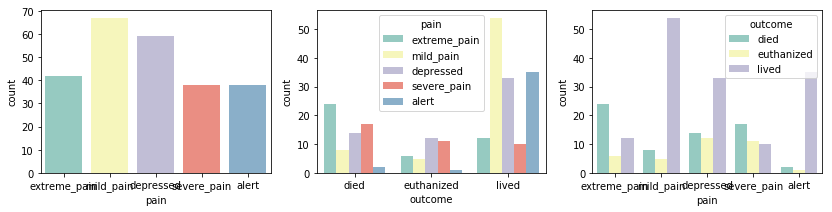

In [24]:
cat_plot("pain", size=(14,3))

peristalsis(연동운동)                        
  - 말의 장내 활동의 표시. 내장이 점점 팽창하거나 말이 더 독성이 생기면서 활동은 감소한다.
  - possible values:
    - 1 = hypermotile
    - 2 = normal
    - 3 = hypomotile
    - 4 = absent

In [25]:
missing_per('peristalsis')

14.715719063545151

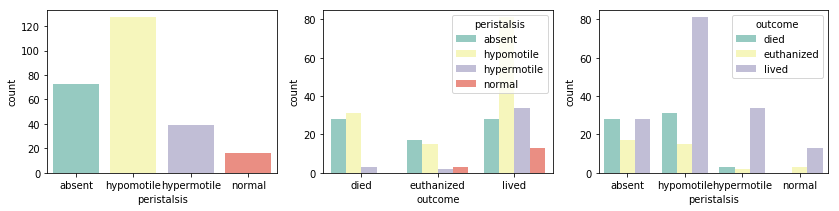

In [26]:
cat_plot("peristalsis", size=(14, 3))

abdominal distension(복부 팽창)
  -  An IMPORTANT parameter.
  - possible values
    - 1 = none
    - 2 = slight
    - 3 = moderate
    - 4 = severe
  - 복부 팽만감을 가진 동물은 고통스럽고 내장 운동성을 감소시킬 수 있습니다.
  - 복부 팽창이 심한 말은 단지 압력을 완화시키기 위해 수술이 필요할 것이다.

In [27]:
missing_per('abdominal_distention')

18.729096989966553

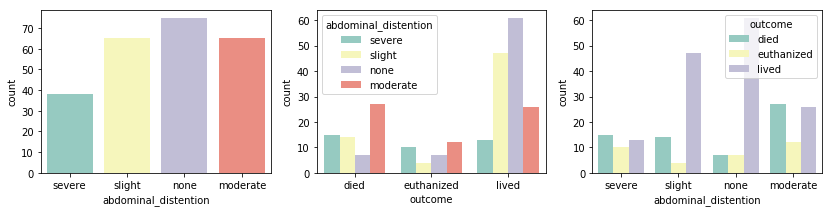

In [28]:
cat_plot("abdominal_distention", size=(14,3))

nasogastric tube(비위 관)
  - 이것은 튜브에서 나오는 가스를 의미합니다.
  - possible values:
    - 1 = none
    - 2 = slight
    - 3 = significant
  - 위에 있는 큰 가스 캡은 말을 불편하게 할 수 있다.

In [29]:
missing_per('nasogastric_tube')

34.782608695652172

In [30]:
df['nasogastric_tube'].value_counts()

slight         101
none            71
significant     23
Name: nasogastric_tube, dtype: int64

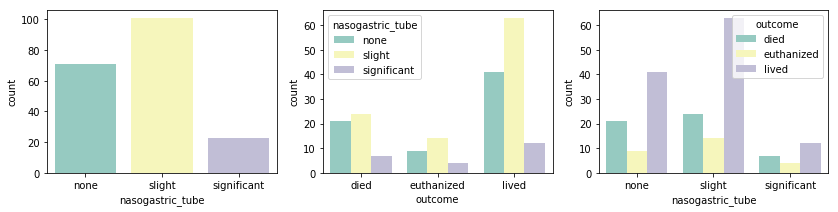

In [31]:
cat_plot("nasogastric_tube", size = (14, 3))

nasogastric reflux(비위 역류)
  - possible values
    - 1 = none
    - 2 = > 1 liter
    - 3 = < 1 liter
  - 역류 량이 많을수록 장의 나머지 부분으로부터의 유체 통로에 심각한 장애물이있을 확률이 높습니다

In [32]:
missing_per('nasogastric_reflux')

35.451505016722408

In [33]:
df['nasogastric_reflux'].value_counts()

none            119
more_1_liter     39
less_1_liter     35
Name: nasogastric_reflux, dtype: int64

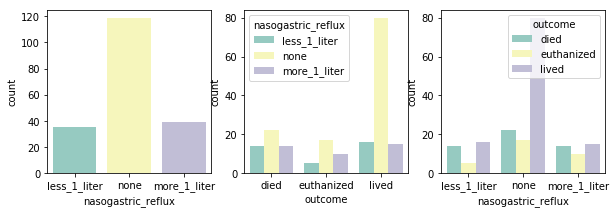

In [34]:
cat_plot("nasogastric_reflux")

nasogastric reflux PH(비위 관성 환류 PH)
  - linear
  - scale is from 0 to 14 with 7 being neutral
  - 정상 값은 3에서 4 범위에 있습니다.

drop시키는게 좋을듯

In [35]:
missing_per('nasogastric_reflux_ph')

82.274247491638803

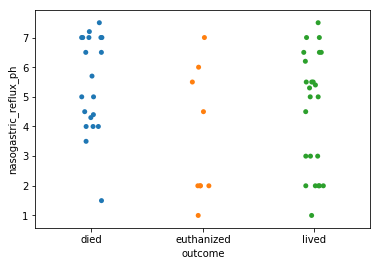

In [36]:
sns.stripplot("outcome", "nasogastric_reflux_ph", data=df, jitter=True)
plt.show()

rectal examination - feces(직장 검사 - 대변)
  - possible values
    - 1 = normal
    - 2 = increased
    - 3 = decreased
    - 4 = absent
  - 배설물이 없다는 것은 아마도 장애를 나타냅니다.

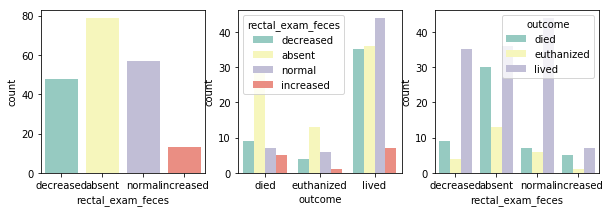

In [37]:
cat_plot("rectal_exam_feces")

abdomen(복부)
  - possible values
    - 1 = normal
    - 2 = other
    - 3 = firm feces in the large intestine
    - 4 = distended small intestine
    - 5 = distended large intestine
  - 3은 아마도 기계적인 충격에 의해 야기된 방해물일 것이다, 그리고 보통 의학적으로 치료된다.
  - 4 및 5는 수술 병변을 나타낸다

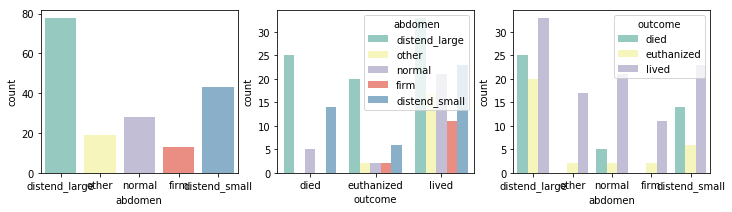

In [38]:
cat_plot("abdomen", size=(12, 3))

packed cell volume
- linear
- 혈액 속의 적혈구의 수
- 정상 범위는 30 ~ 50입니다. 혈액 순환이 원활 해지거나 동물이 탈수됨에 따라 혈중 농도가 상승합니다.

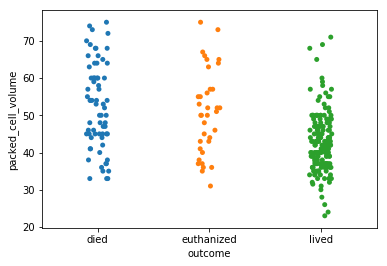

In [39]:
sns.stripplot("outcome", "packed_cell_volume", data=df, jitter=True)
plt.show()

total protein(총 단백질)
  - linear
  - 정상적인 값은 6-7.5 (gms / dL) 범위입니다
  - 값이 높을수록 탈수량이 커집니다.

In [40]:
missing_per('total_protein')

11.036789297658862

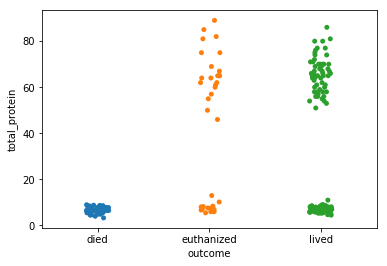

In [41]:
sns.stripplot("outcome", "total_protein", data=df, jitter=True)
plt.show()

abdominocentesis appearance(복강경 외관)
  - 말의 복부에 바늘을 넣고 복강으로부터 유체를 얻는다.
  - possible values:
    - 1 = clear
    - 2 = cloudy
    - 3 = serosanguinous
  - normal fluid is clear while cloudy or serosanguinous indicates a compromised gut

In [42]:
missing_per('abdomo_appearance')

55.18394648829431

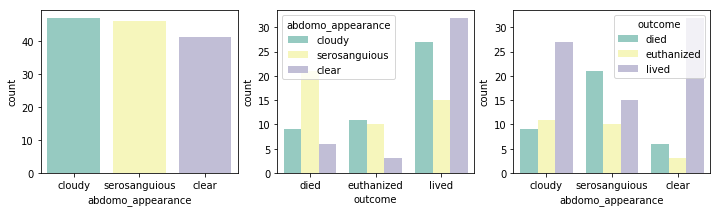

In [43]:
cat_plot("abdomo_appearance", size=(12, 3))

abdomcentesis total protein(복강 내 총 단백질)
  - linear
  - 단백질 수준이 높을수록 손상된 창자가 더 많을 것입니다. 값은 gms / dL 단위입니다.

drop 시키는거 고려

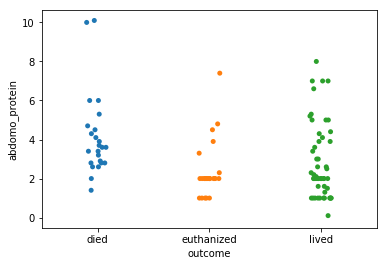

In [44]:
sns.stripplot("outcome", "abdomo_protein", data=df, jitter=True)
plt.show()

surgical lesion? (외과 적 병변)
  - retrospectively, was the problem (lesion) surgical?
  -  colic의 원인을 찾으려면 일단 배를 갈라봐야 알수 있기 때문에 수술하는과정에서 알아내거나(Yes) 부검해서 알아낸다(no).
  - possible values:
    - 1 = Yes
    - 2 = No

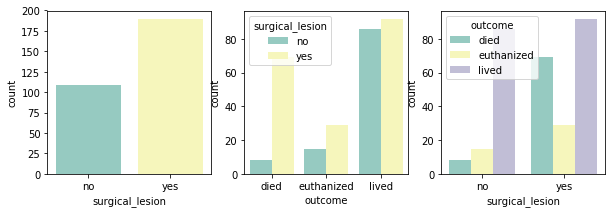

In [45]:
cat_plot("surgical_lesion")

25, 26, 27: type of lesion
- 첫 번째 숫자는 병변의 위치입니다.
  - 1 = gastric (위(胃)의)
  - 2 = sm intestine (sm 창자)
  - 3 = lg colon (결장)
  - 4 = lg colon and cecum (결장과 맹장)
  - 5 = cecum (맹장)
  - 6 = transverse colon (횡행결장)
  - 7 = retum/descending colon (/하행 결장)
  - 8 = uterus (자궁)
  - 9 = bladder (방광)
  - 11 = all intestinal sites (모든 창자 부위)
  - 00 = none (없음)
  
  
- 두 번째 숫자는 유형입니다.
  - 1 = simple (단순한)
  - 2 = strangulation (교살)
  - 3 = inflammation (염증)
  - 4 = other
  
  
- 세 번째 숫자는 하위 유형입니다.
  - 1 = mechanical
  - 2 = paralytic
  - 0 = n/a
  
  
- 네 번째 숫자는 특정 코드입니다.
  -  1 = obturation
  -  2 = intrinsic
  -  3 = extrinsic
  -  4 = adynamic
  -  5 = volvulus/torsion
  -  6 = intussuption
  -  7 = thromboembolic
  -  8 = hernia
  -  9 = lipoma/slenic incarceration
  -  10 = displacement
  -  0 = n/a

cp_data
  - is pathology data present for this case?
    - 1 = Yes
    - 2 = No
  - 이러한 변수는 병리학 데이터가 포함되지 않거나 수집되지 않기 때문에 중요하지 않다.

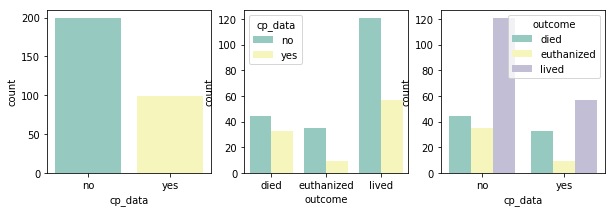

In [46]:
cat_plot("cp_data")

outcome(결과)
  - what eventually happened to the horse?
  - possible values:
    - 1 = lived
    - 2 = died
    - 3 = was euthanized

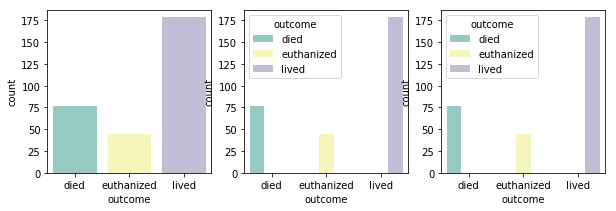

In [47]:
cat_plot("outcome")

### Chi Square & F 

In [48]:
# from scipy.stats import chisquare
# from IPython.display import display

In [49]:
# for cat in cate:
#     statistic, p = chisquare(df[cat].apply(str).value_counts())
#     chisq = {"statistic" : statistic, "p-value" : p.round(2)}
#     print(cat)
#     display(pd.DataFrame(index=["Chi Square"], data=chisq)[["statistic","p-value"]])

In [50]:
# cate_str = 'outcome ~ C(surgery) + C(age) + C(temp_of_extremities) + C(peripheral_pulse) + C(mucous_membrane) + C(capillary_refill_time) + C(pain) + C(peristalsis) + C(abdominal_distention) + C(nasogastric_tube) + C(nasogastric_reflux) + C(rectal_exam_feces) + C(abdomen) + C(abdomo_appearance) + C(surgical_lesion) + C(cp_data)'

In [51]:
# model = sm.OLS.from_formula(cate_str+'-1', data=df)
# result = model.fit()
# sm.stats.anova_lm(result, typ=2)

Missing values: 30% of the values are missing

## Missing value

In [52]:
df['rectal_temp'].fillna(value=df['rectal_temp'].mode()[0], inplace=True)
df['pulse'].fillna(value=df['pulse'].mean(), inplace=True)
df['respiratory_rate'].fillna(value=df['respiratory_rate'].mean(), inplace=True)
df['temp_of_extremities'].fillna(value=df['temp_of_extremities'].mode()[0], inplace=True)
df['peripheral_pulse'].fillna(value=df['peripheral_pulse'].mode()[0], inplace=True)
df['mucous_membrane'].fillna(value=df['mucous_membrane'].mode()[0], inplace=True)
df['capillary_refill_time'].fillna(value=df['capillary_refill_time'].mode()[0], inplace=True)
df['pain'].fillna(value=df['pain'].mode()[0], inplace=True)
df['peristalsis'].fillna(value=df['peristalsis'].mode()[0], inplace=True)
df['abdominal_distention'].fillna(value=df['abdominal_distention'].mode()[0], inplace=True)
df['nasogastric_tube'].fillna(value=df['nasogastric_tube'].mode()[0], inplace=True)
df['nasogastric_reflux'].fillna(value=df['nasogastric_reflux'].mode()[0], inplace=True)
df['nasogastric_reflux_ph'].fillna(value=df['nasogastric_reflux_ph'].mean(), inplace=True)
df['rectal_exam_feces'].fillna(value=df['rectal_exam_feces'].mode()[0], inplace=True)
df['abdomen'].fillna(value=df['abdomen'].mode()[0], inplace=True)
df['packed_cell_volume'].fillna(value=df['packed_cell_volume'].mean(), inplace=True)
df['total_protein'].fillna(value=df.total_protein.mode().sum()/len(df.total_protein.mode()), inplace=True)
df['abdomo_appearance'].fillna(value=df['abdomo_appearance'].mode()[0], inplace=True)
df['abdomo_protein'].fillna(value=df['abdomo_protein'].mode()[0], inplace=True)

## Feature selection

In [53]:
numeric_feat = ['rectal_temp', 'pulse', 'packed_cell_volume', 'total_protein', 'outcome']

cate_feat = ['surgery', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane',
        'capillary_refill_time', 'pain', 'abdominal_distention']

feat_selec = cate_feat + numeric_feat

In [63]:
dfX = df[feat_selec].drop('outcome', axis=1)
dfy = df[feat_selec]['outcome']

X_train, X_test, y_train, y_test = train_test_split(dfX, dfy, test_size=0.20, random_state=10)

## replace 

In [55]:
df['surgery'].replace({'yes': 1, 'no': 2}, inplace=True)
df['age'].replace({'adult': 1, 'young': 2}, inplace=True)
df['temp_of_extremities'].replace({'normal': 1, 'warm': 2, 'cool': 3, 'cold': 4}, inplace=True)
df['peripheral_pulse'].replace({'normal': 1, 'increased': 2, 'reduced': 3, 'absent': 4}, inplace=True)
df['mucous_membrane'].replace({'normal_pink': 1, 'bright_pink': 2, 'pale_pink': 3, 'pale_cyanotic': 4, 'bright_red': 5, 'dark_cyanotic': 6}, inplace=True)
df['capillary_refill_time'].replace({'less_3_sec': 1, 'more_3_sec': 2, '3': 2}, inplace=True)
df['pain'].replace({'alert': 1, 'depressed': 2, 'mild_pain': 3, 'severe_pain': 4, 'extreme_pain': 5}, inplace=True)
df['peristalsis'].replace({'hypermotile': 1, 'normal': 2, 'hypomotile': 3, 'absent': 4}, inplace=True)
df['abdominal_distention'].replace({'none': 1, 'slight': 2, 'moderate': 3, 'severe': 4}, inplace=True)
df['nasogastric_tube'].replace({'none': 1, 'slight': 2, 'significant': 3}, inplace=True)
df['nasogastric_reflux'].replace({'none': 1, 'more_1_liter': 2, 'less_1_liter': 3}, inplace=True)
df['rectal_exam_feces'].replace({'normal': 1, 'increased': 2, 'decreased': 3, 'absent': 4}, inplace=True)
df['abdomen'].replace({'normal': 1, 'other': 2, 'firm': 3, 'distend_small': 4, 'distend_large': 5}, inplace=True)
df['abdomo_appearance'].replace({'clear': 1, 'cloudy': 2, 'serosanguious': 3}, inplace=True)
df['surgical_lesion'].replace({'yes': 1, 'no': 2}, inplace=True)
df['cp_data'].replace({'yes': 1, 'no': 2}, inplace=True)
df['outcome'].replace({'lived': 1, 'died': 2, 'euthanized':3}, inplace=True)

## Model selection

In [56]:
algo = {'OVR':OneVsRestClassifier(LogisticRegression()),
        'OVO':OneVsOneClassifier(LogisticRegression()),
        'LR':LogisticRegression(),
        'DT':DecisionTreeClassifier(),
        'RFC':RandomForestClassifier(n_estimators=100),
        'SVM':SVC(gamma=0.001),
        'KNN':KNeighborsClassifier(n_neighbors=10)}

In [72]:
for k, v in algo.items():
    model = v
    model.fit(X_train, y_train)
    print('Acurracy of ' + k + ' is {0:.2f}'.format(model.score(X_test, y_test)*100))

Acurracy of OVR is 78.33
Acurracy of OVO is 76.67
Acurracy of LR is 78.33
Acurracy of DT is 71.67
Acurracy of RFC is 81.67
Acurracy of SVM is 81.67
Acurracy of KNN is 80.00


### OVS LogisticRegression

In [71]:
model_OVS= OneVsRestClassifier(LogisticRegression())
model_OVS.fit(X_train, y_train)

print(classification_report(y_test, model_OVS.predict(X_test)))

             precision    recall  f1-score   support

          1       0.83      0.93      0.88        43
          2       0.60      0.67      0.63         9
          3       0.50      0.12      0.20         8

avg / total       0.75      0.78      0.75        60



### RandomForest

In [66]:
model_rfc = RandomForestClassifier(n_estimators=30, random_state=None)
model_rfc.fit(X_train, y_train)

print(classification_report(y_test, model_rfc.predict(X_test)))

             precision    recall  f1-score   support

          1       0.85      0.91      0.88        43
          2       0.46      0.67      0.55         9
          3       1.00      0.12      0.22         8

avg / total       0.81      0.77      0.74        60



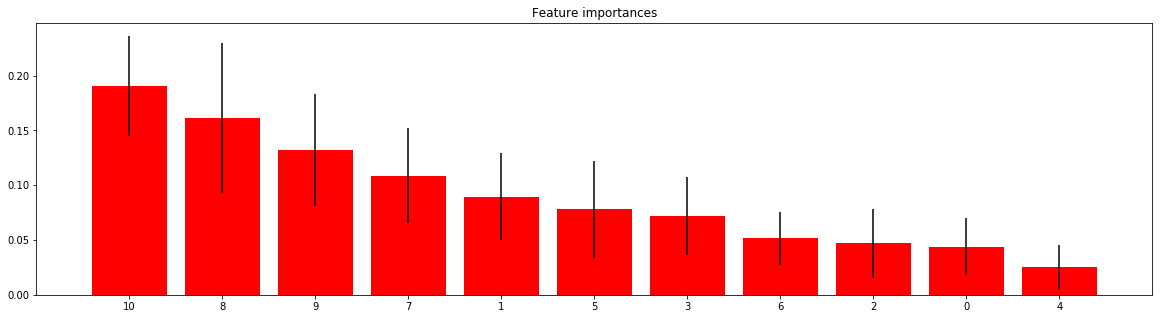

In [67]:
importances = model_rfc.feature_importances_

std = np.std([tree.feature_importances_ for tree in model_rfc.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color='r', yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [68]:
imp_dict = dict()
for i, j in zip(X_train.columns, importances):
    imp_dict[i] = j

In [69]:
import operator
sorted_x = sorted(imp_dict.items(), key=operator.itemgetter(1))
aa = pd.DataFrame(sorted_x, columns=['Feature', 'importance(%)'])

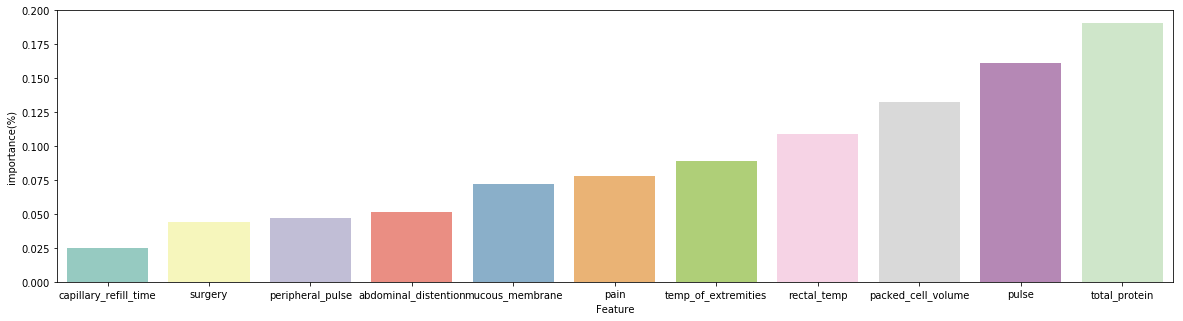

In [70]:
plt.figure(figsize=(20, 5))
sns.barplot(x='Feature', y='importance(%)', data=aa, palette="Set3")
plt.show()

### softmax Regression

In [61]:
# dfXX2 = dfX.as_matrix()
# dfyy2 = pd.get_dummies(dfy).as_matrix()

In [62]:
# dfXX_test = X_test.as_matrix()
# dfyy_test = pd.get_dummies(y_test).as_matrix()

In [ ]:
# learning_rate = 0.01

# # input place holders
# nb_classes = 3
# X = tf.placeholder(tf.float32, [None, dfXX.shape[1]])
# Y = tf.placeholder(tf.float32, [None, nb_classes])

# # weights & bias for nn layers
# W1 = tf.Variable(tf.random_normal([dfXX.shape[1], 16]))
# b1 = tf.Variable(tf.random_normal([16]))
# L1 = tf.nn.relu(tf.matmul(X, W1) + b1)

# W2 = tf.Variable(tf.random_normal([16, 16]))
# b2 = tf.Variable(tf.random_normal([16]))
# L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)

# W3 = tf.Variable(tf.random_normal([16, nb_classes]))
# b3 = tf.Variable(tf.random_normal([nb_classes]))

# hypothesis = tf.matmul(L2, W3) + b3
# # hypothesis = tf.nn.softmax(tf.matmul(L2, W3) + b3)

# cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=hypothesis, labels=Y))
# optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# test_pred = []
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())

#     for step in range(20001):
#         sess.run(optimizer, feed_dict={X: dfXX, Y: dfyy})
#         if step % 2000 == 0:
#             print(step, sess.run(cost, feed_dict={X: dfXX, Y: dfyy}))

#     for i in range(len(dfXX_test)):
# #         print('--------------')

#         a = sess.run(hypothesis, feed_dict={X: [list(dfXX_test[i])]})
# #         print(a, sess.run(tf.argmax(a, 1)), dfyy_test[i])
#         test_pred.append(sess.run(tf.argmax(a, 1)))

In [ ]:
# test_pred1 = []
# for i in range(len(test_pred)):
#     test_pred1.append(int(test_pred[i])+1)

In [ ]:
# print(classification_report(y_test, test_pred1))

# test

In [73]:
df_test = pd.read_csv('horse-colic.test.csv')

In [74]:
df_test.replace({'?': None}, inplace=True)
df_test['surgery'].fillna(value=df['surgery'].mode()[0], inplace=True)
df_test['rectal_temp'].fillna(value=df['rectal_temp'].mode()[0], inplace=True)
df_test['pulse'].fillna(value=df['pulse'].mean(), inplace=True)
df_test['respiratory_rate'].fillna(value=df['respiratory_rate'].mean(), inplace=True)
df_test['temp_of_extremities'].fillna(value=df['temp_of_extremities'].mode()[0], inplace=True)
df_test['peripheral_pulse'].fillna(value=df['peripheral_pulse'].mode()[0], inplace=True)
df_test['mucous_membrane'].fillna(value=df['mucous_membrane'].mode()[0], inplace=True)
df_test['capillary_refill_time'].fillna(value=df['capillary_refill_time'].mode()[0], inplace=True)
df_test['pain'].fillna(value=df['pain'].mode()[0], inplace=True)
df_test['peristalsis'].fillna(value=df['peristalsis'].mode()[0], inplace=True)
df_test['abdominal_distention'].fillna(value=df['abdominal_distention'].mode()[0], inplace=True)
df_test['nasogastric_tube'].fillna(value=df['nasogastric_tube'].mode()[0], inplace=True)
df_test['nasogastric_reflux'].fillna(value=df['nasogastric_reflux'].mode()[0], inplace=True)
df_test['nasogastric_reflux_ph'].fillna(value=df['nasogastric_reflux_ph'].mean(), inplace=True)
df_test['rectal_exam_feces'].fillna(value=df['rectal_exam_feces'].mode()[0], inplace=True)
df_test['abdomen'].fillna(value=df['abdomen'].mode()[0], inplace=True)
df_test['packed_cell_volume'].fillna(value=df['packed_cell_volume'].mean(), inplace=True)
df_test['total_protein'].fillna(value=df.total_protein.mode().sum()/len(df.total_protein.mode()), inplace=True)
df_test['abdomo_appearance'].fillna(value=df['abdomo_appearance'].mode()[0], inplace=True)
df_test['abdomo_protein'].fillna(value=df['abdomo_protein'].mode()[0], inplace=True)
df_test.dropna(inplace=True)

In [75]:
df_test = df_test[feat_selec]

In [76]:
df_testX = df_test.drop('outcome', axis=1)
df_testy = df_test['outcome'].astype(int)

In [77]:
print(classification_report(df_testy, model_OVS.predict(df_testX)))

             precision    recall  f1-score   support

          1       0.82      0.87      0.85        47
          2       0.58      0.58      0.58        12
          3       0.40      0.25      0.31         8

avg / total       0.73      0.75      0.73        67



In [78]:
print(classification_report(df_testy, model_rfc.predict(df_testX)))

             precision    recall  f1-score   support

          1       0.83      0.83      0.83        47
          2       0.47      0.58      0.52        12
          3       0.60      0.38      0.46         8

avg / total       0.74      0.73      0.73        67



In [79]:
print(classification_report(df_testy, model.predict(df_testX)))

             precision    recall  f1-score   support

          1       0.82      0.87      0.85        47
          2       0.56      0.75      0.64        12
          3       1.00      0.12      0.22         8

avg / total       0.80      0.76      0.73        67



### softmax Regression

In [80]:
dfXX = dfX.as_matrix()
dfyy = pd.get_dummies(dfy).as_matrix()

In [81]:
dfXX_test = X_test.as_matrix()
dfyy_test = pd.get_dummies(y_test).as_matrix()

In [82]:
learning_rate = 0.01

# input place holders
nb_classes = 3
X = tf.placeholder(tf.float32, [None, dfXX.shape[1]])
Y = tf.placeholder(tf.float32, [None, nb_classes])

# weights & bias for nn layers
W1 = tf.Variable(tf.random_normal([dfXX.shape[1], 16]))
b1 = tf.Variable(tf.random_normal([16]))
L1 = tf.nn.relu(tf.matmul(X, W1) + b1)

W2 = tf.Variable(tf.random_normal([16, 16]))
b2 = tf.Variable(tf.random_normal([16]))
L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)

W3 = tf.Variable(tf.random_normal([16, nb_classes]))
b3 = tf.Variable(tf.random_normal([nb_classes]))

hypothesis = tf.matmul(L2, W3) + b3
# hypothesis = tf.nn.softmax(tf.matmul(L2, W3) + b3)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=hypothesis, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

test_pred = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for step in range(20001):
        sess.run(optimizer, feed_dict={X: dfXX, Y: dfyy})
        if step % 2000 == 0:
            print(step, sess.run(cost, feed_dict={X: dfXX, Y: dfyy}))

    for i in range(len(dfXX_test)):
#         print('--------------')

        a = sess.run(hypothesis, feed_dict={X: [list(dfXX_test[i])]})
#         print(a, sess.run(tf.argmax(a, 1)), dfyy_test[i])
        test_pred.append(sess.run(tf.argmax(a, 1)))

0 408.995
2000 0.637241
4000 0.567889
6000 0.422419
8000 0.367034
10000 0.440722
12000 0.397628
14000 0.314281
16000 0.307175
18000 0.299828
20000 0.307582


In [83]:
test_pred1 = []
for i in range(len(test_pred)):
    test_pred1.append(int(test_pred[i])+1)

In [84]:
print(classification_report(y_test, test_pred1))

             precision    recall  f1-score   support

          1       0.91      0.98      0.94        43
          2       0.88      0.78      0.82         9
          3       1.00      0.75      0.86         8

avg / total       0.92      0.92      0.91        60

